<center> <h1>Final Project

- USC ID - 7896870417
- Name - Akash Vishwakarma
- Username (github) - joyboy5477

In [4]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

from tensorflow.keras.layers import GlobalAveragePooling2D,MaxPooling2D

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input



import warnings
warnings.filterwarnings("ignore")

# Part a) - Data DOwnloading

In [90]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [93]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Part b) Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [95]:
import random
import tensorflow as tf
from PIL import Image 

def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        
        
        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    return X, y

In [96]:
def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

In [97]:
# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], [] # contains frost,png paths
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        

In [98]:
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

In [99]:
def shapeSetting(images, labels):
  images.set_shape([None, 299, 299,3])
  labels.set_shape([None])
  return images, labels

tf_dataset_train=tf_dataset_train.map(shapeSetting)
tf_dataset_val=tf_dataset_val.map(shapeSetting)
tf_dataset_test=tf_dataset_test.map(shapeSetting)
tf_dataset_train

<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Part c - i) - Data Augmentation

In [100]:
#keras augmentation
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

def augment(images, labels):
  images=data_augmentation(images)
  return images, labels

tf_dataset_train=tf_dataset_train.map(augment)

# Part c) - ii) CNN+MLP

Epoch 1/20
442/442 [==============================] - 3025s 7s/step - loss: 37.5580 - accuracy: 0.7276 - val_loss: 10.8602 - val_accuracy: 0.8683
Epoch 2/20
442/442 [==============================] - 3264s 7s/step - loss: 6.4372 - accuracy: 0.7838 - val_loss: 7.1651 - val_accuracy: 0.7542
Epoch 3/20
442/442 [==============================] - 2729s 6s/step - loss: 8.8660 - accuracy: 0.7853 - val_loss: 13.6878 - val_accuracy: 0.3123
Epoch 4/20
442/442 [==============================] - 2624s 6s/step - loss: 5.9436 - accuracy: 0.7983 - val_loss: 6.1788 - val_accuracy: 0.7334
Epoch 5/20
442/442 [==============================] - 2773s 6s/step - loss: 5.0234 - accuracy: 0.8316 - val_loss: 4.1895 - val_accuracy: 0.6491
Epoch 6/20
442/442 [==============================] - 2731s 6s/step - loss: 3.4442 - accuracy: 0.8659 - val_loss: 4.7375 - val_accuracy: 0.6997
Epoch 7/20
442/442 [==============================] - 2590s 6s/step - loss: 2.6870 - accuracy: 0.8788 - val_loss: 2.6094 - val_accura

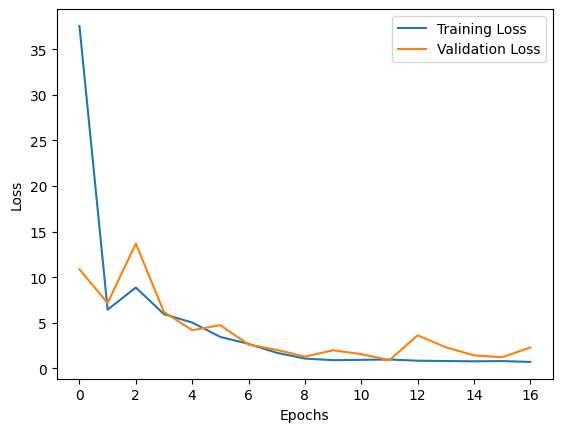

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
noofclasses=2
#model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layer with dropout and L2 regularization
model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.3))

# Output layer
model.add(layers.Dense(noofclasses, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train, 
history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Plot training and validation errors vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

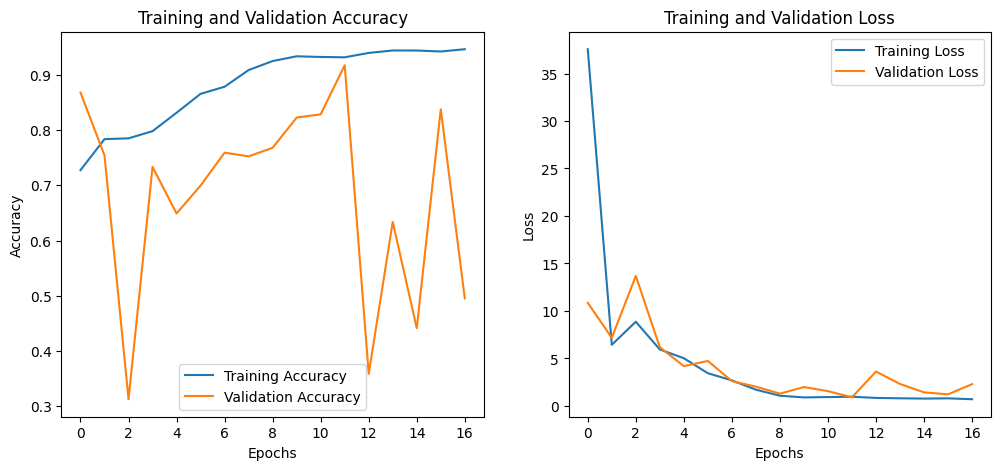

In [125]:
# cnn plots
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [49]:
# Make predictions on the test set
test_predictions = model.predict(tf_dataset_test)
test_predictions = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels

250/250 [==============================] - 434s 2s/step


# Part c) - iii) - accuracy report of cnn model

In [61]:
test_labels = []
for _, labels in tf_dataset_test:
    test_labels.extend(labels.numpy())

test_predictionsm = model.predict(tf_dataset_test)
test_predictionsm = np.argmax(test_predictionsm, axis=1)
precisionm = precision_score(test_labels, test_predictionsm)
recallm = recall_score(test_labels, test_predictionsm)
f1m = f1_score(test_labels, test_predictionsm)

print("Precision: {:.4f}".format(precisionm))
print("Recall: {:.4f}".format(recallm))
print("F1 Score: {:.4f}".format(f1m))

print(classification_report(test_labels, test_predictionsm, target_names=['Background', 'Frost']))

250/250 [==============================] - 401s 2s/step
Precision: 0.7264
Recall: 0.6268
F1 Score: 0.6729
              precision    recall  f1-score   support

  Background       0.28      0.38      0.32      2198
       Frost       0.73      0.63      0.67      5774

    accuracy                           0.56      7972
   macro avg       0.50      0.50      0.50      7972
weighted avg       0.60      0.56      0.58      7972



# Part d ) - Treansfer Learning 
data augmentation is already done so ii is completed

### Resnet50 - iii,iv

Epoch 1/20
442/442 [==============================] - 2583s 6s/step - loss: 0.0927 - accuracy: 0.9674 - val_loss: 1.6888 - val_accuracy: 0.5397
Epoch 2/20
442/442 [==============================] - 2822s 6s/step - loss: 0.0461 - accuracy: 0.9831 - val_loss: 1.4343 - val_accuracy: 0.6109
Epoch 3/20
442/442 [==============================] - 2745s 6s/step - loss: 0.0394 - accuracy: 0.9868 - val_loss: 2.5712 - val_accuracy: 0.4832
Epoch 4/20
442/442 [==============================] - 2761s 6s/step - loss: 0.0355 - accuracy: 0.9880 - val_loss: 3.1126 - val_accuracy: 0.4153
Epoch 5/20
442/442 [==============================] - 2679s 6s/step - loss: 0.0292 - accuracy: 0.9897 - val_loss: 2.7083 - val_accuracy: 0.4752
Epoch 6/20
442/442 [==============================] - 2503s 6s/step - loss: 0.0295 - accuracy: 0.9899 - val_loss: 3.4773 - val_accuracy: 0.3933
Epoch 7/20
442/442 [==============================] - 2441s 6s/step - loss: 0.0301 - accuracy: 0.9894 - val_loss: 3.3808 - val_accuracy:

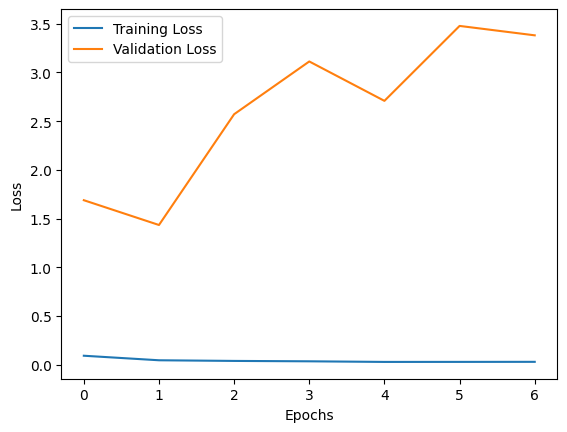

In [59]:
# Resnet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model, exclude the top (fully connected) layer
base_modelres = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers of the base model
for layer in base_modelres.layers:
    layer.trainable = False


# Adding new layers
x = base_modelres.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) 
x = BatchNormalization()(x) # bacth normalization
x = Dropout(0.3)(x) # dropout
predictions = Dense(2, activation='softmax')(x)

# Model
modelres = Model(inputs=base_modelres.input, outputs=predictions)
# compile
modelres.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
historyres = modelres.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])

#plotting
plt.plot(historyres.history['loss'], label='Training Loss')
plt.plot(historyres.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

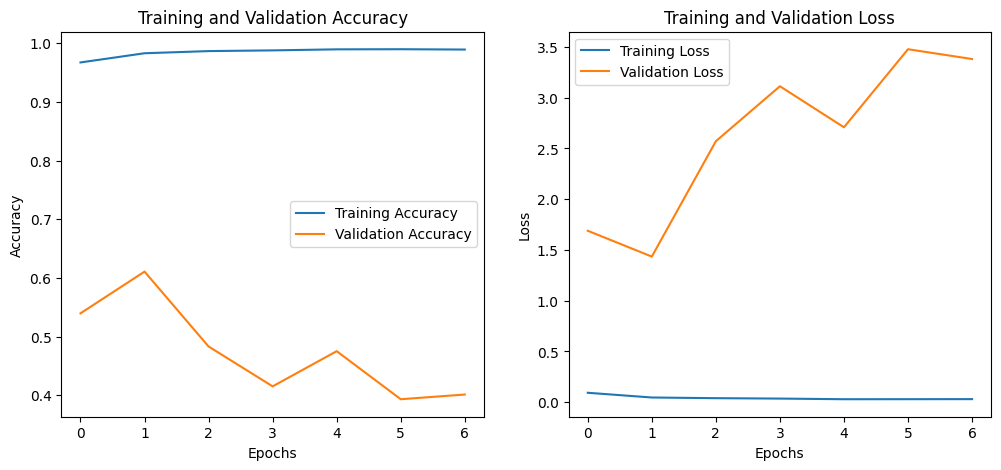

In [124]:
# resnet50 plots
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historyres.history['accuracy'], label='Training Accuracy')
plt.plot(historyres.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(historyres.history['loss'], label='Training Loss')
plt.plot(historyres.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### EfficientNetB0

In [113]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Adding new layers to the model
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  #batch normalization
x = Dropout(0.3)(x)  # dropout

predictions = Dense(2, activation='softmax', name='output_efficientnet')(x)

model_efficientnet = Model(inputs=base_model.input, outputs=predictions)

# Compile
model_efficientnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history_efficientnet = model_efficientnet.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])


Epoch 1/20
442/442 [==============================] - 1366s 3s/step - loss: 0.1028 - accuracy: 0.9628 - val_loss: 1.0569 - val_accuracy: 0.6782
Epoch 2/20
442/442 [==============================] - 1163s 3s/step - loss: 0.0518 - accuracy: 0.9814 - val_loss: 2.0781 - val_accuracy: 0.5729
Epoch 3/20
442/442 [==============================] - 1138s 3s/step - loss: 0.0475 - accuracy: 0.9836 - val_loss: 1.3782 - val_accuracy: 0.6685
Epoch 4/20
442/442 [==============================] - 1150s 3s/step - loss: 0.0413 - accuracy: 0.9842 - val_loss: 0.8552 - val_accuracy: 0.7698
Epoch 5/20
442/442 [==============================] - 1108s 3s/step - loss: 0.0371 - accuracy: 0.9865 - val_loss: 1.3075 - val_accuracy: 0.7124
Epoch 6/20
442/442 [==============================] - 1107s 3s/step - loss: 0.0316 - accuracy: 0.9883 - val_loss: 2.1213 - val_accuracy: 0.5941
Epoch 7/20
442/442 [==============================] - 1308s 3s/step - loss: 0.0329 - accuracy: 0.9886 - val_loss: 1.0512 - val_accuracy:

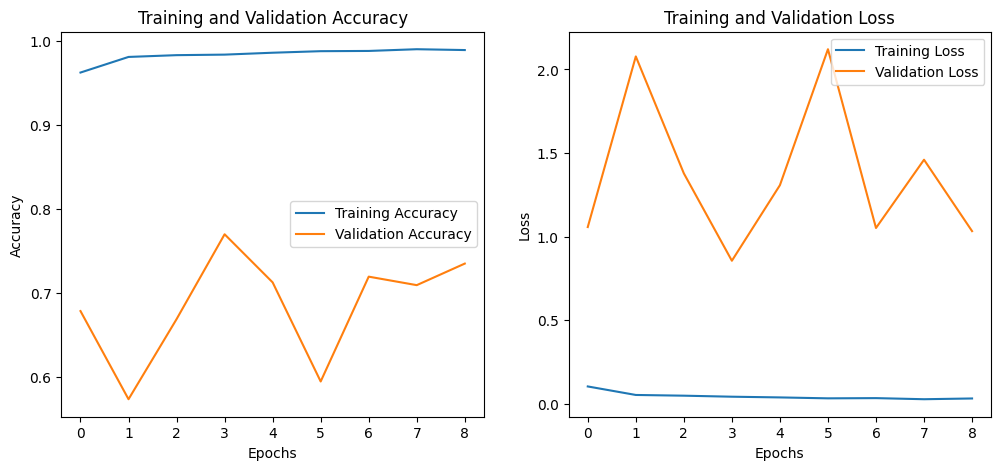

In [120]:
# efficient plots
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Training Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### VGG16

In [115]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


In [116]:
# Load pre-trained VGG16 model, exclude the top (fully connected) layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False
# Adding layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

# model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)


In [117]:
model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [118]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_vgg16 = model_vgg16.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)


Epoch 1/20
442/442 [==============================] - 4070s 9s/step - loss: 0.1468 - accuracy: 0.9444 - val_loss: 0.7976 - val_accuracy: 0.7559
Epoch 2/20
442/442 [==============================] - 3976s 9s/step - loss: 0.0785 - accuracy: 0.9723 - val_loss: 1.1430 - val_accuracy: 0.7167
Epoch 3/20
442/442 [==============================] - 3989s 9s/step - loss: 0.0592 - accuracy: 0.9775 - val_loss: 1.3985 - val_accuracy: 0.6588
Epoch 4/20
442/442 [==============================] - 3997s 9s/step - loss: 0.0563 - accuracy: 0.9800 - val_loss: 1.2842 - val_accuracy: 0.6891
Epoch 5/20
442/442 [==============================] - 4016s 9s/step - loss: 0.0502 - accuracy: 0.9817 - val_loss: 1.5352 - val_accuracy: 0.6891
Epoch 6/20
442/442 [==============================] - 4056s 9s/step - loss: 0.0497 - accuracy: 0.9820 - val_loss: 1.5582 - val_accuracy: 0.6778


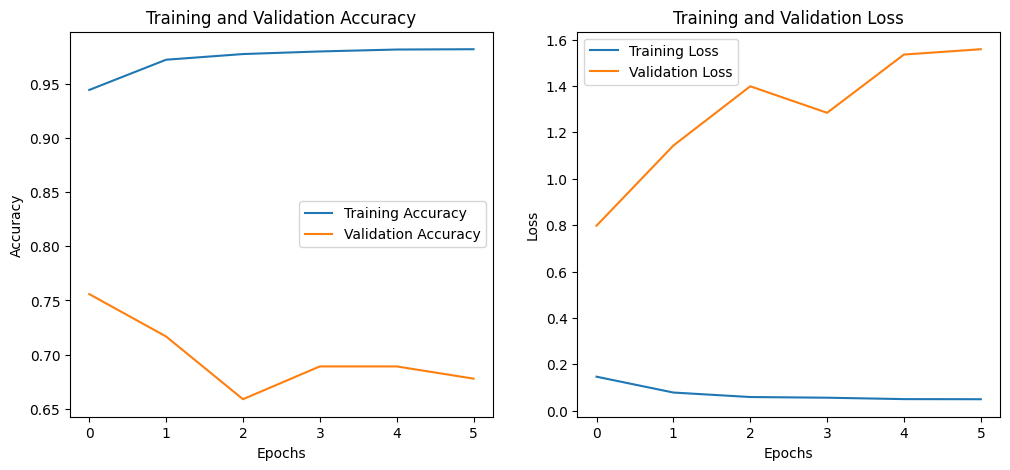

In [119]:
# VGGG16 Plot
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Part d) - vi) - accuracy of resnet50,efficientnetB0 and vgg16

In [60]:
# - accuracy of resnet50

test_predictions = modelres.predict(tf_dataset_test)
test_predictions = np.argmax(test_predictions, axis=1)

# test_labels = []
# for _, labels in tf_dataset_test:
#     test_labels.extend(labels.numpy())
    
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

print(classification_report(test_labels, test_predictions, target_names=['Background', 'Frost']))

250/250 [==============================] - 912s 4s/step
Precision: 0.7254
Recall: 0.7717
F1 Score: 0.7478
              precision    recall  f1-score   support

  Background       0.28      0.23      0.25      2198
       Frost       0.73      0.77      0.75      5774

    accuracy                           0.62      7972
   macro avg       0.50      0.50      0.50      7972
weighted avg       0.60      0.62      0.61      7972



In [121]:
#efficeint - accuracy
test_predictionseff = model_efficientnet.predict(tf_dataset_test)
test_predictionseff = np.argmax(test_predictionseff, axis=1)

precision = precision_score(test_labels, test_predictionseff)
recall = recall_score(test_labels, test_predictionseff)
f1 = f1_score(test_labels, test_predictionseff)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

print(classification_report(test_labels, test_predictionseff, target_names=['Background', 'Frost']))

250/250 [==============================] - 385s 2s/step
Precision: 0.7286
Recall: 0.8048
F1 Score: 0.7648
              precision    recall  f1-score   support

  Background       0.29      0.21      0.25      2198
       Frost       0.73      0.80      0.76      5774

    accuracy                           0.64      7972
   macro avg       0.51      0.51      0.51      7972
weighted avg       0.61      0.64      0.62      7972



In [123]:
# vgg -accoracy
test_predictionsvgg = model_vgg16.predict(tf_dataset_test)
test_predictionsvgg = np.argmax(test_predictionsvgg, axis=1)  # Convert probabilities to class labels

    
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(test_labels, test_predictionsvgg)
recall = recall_score(test_labels, test_predictionsvgg)
f1 = f1_score(test_labels, test_predictionsvgg)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

print(classification_report(test_labels, test_predictionsvgg, target_names=['Background', 'Frost']))

250/250 [==============================] - 1476s 6s/step
Precision: 0.7221
Recall: 0.7582
F1 Score: 0.7397
              precision    recall  f1-score   support

  Background       0.27      0.23      0.25      2198
       Frost       0.72      0.76      0.74      5774

    accuracy                           0.61      7972
   macro avg       0.50      0.50      0.49      7972
weighted avg       0.60      0.61      0.60      7972



# Part d) - vi) -  Compare the results

The transfer learning models, particularly EfficientNetB0, slightly outperform the custom CNN + MLP model in terms of precision, recall, F1 score, and overall accuracy. This suggests that transfer learning, leveraging pre-trained models, provides a strong starting point and likely captures more complex features than the custom CNN + MLP model.
The slight higher F1 scores and accuracies of the transfer learning models indicate their better generalization capabilities for this classification task. The use of these advanced architectures allows the models to leverage learned patterns from a wide array of image data, enhancing their performance on specific tasks like frost detection.
Among the transfer learning models, EfficientNetB0 stands out with the highest recall, F1 score, and overall accuracy, suggesting it is the most suitable model for this particular task. However overall we can say that the models exhibit consistent performance. 